In [1]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

In [3]:
df = pd.read_excel('/Users/yvette/Desktop/data/List of anchor words.xlsx')

word_groups = {}

for idx, row in df.iterrows():
    dim_name = row['dimension']
    positive = row['positive']
    negative = row['negative']

    if dim_name not in word_groups:
        word_groups[dim_name] = {'positive': [], 'negative': []}
        
    word_groups[dim_name]['positive'].append(positive)
    word_groups[dim_name]['negative'].append(negative)

def clean_word_groups(word_groups):
    # Loop through each group and clean the 'positive' and 'negative' lists
    for group in word_groups.values():
        group['positive'] = [word.lower().replace(" ", "_") for word in group['positive'] if word is not np.nan]
        group['negative'] = [word.lower().replace(" ", "_") for word in group['negative'] if word is not np.nan]
    return word_groups

# Clean the word groups
word_groups = clean_word_groups(word_groups)

print(word_groups)


{'Democracy  vs.  Dictatorship': {'positive': ['democracy', 'polyarchy', 'pluralism', 'egalitarian', 'consensual', 'deliberative', 'participatory', 'liberal', 'feminism', 'social_democracy', 'representative'], 'negative': ['dictatorship', 'autocracy', 'authoritarianism', 'populism', 'erosion', 'coup', 'fascism', 'conservatism', 'backsliding', 'totalitarianism', 'oligarchy']}, 'Electoral': {'positive': ['directly_elected', 'electoral_competition', 'electoral_integrity', 'multiparty', 'multi_party', 'free_speech', 'free_press'], 'negative': ['appointed', 'appointment', 'electoral_authoritarianism', 'electoral_fraud', 'single_party', 'censorship', 'propaganda']}, 'Liberal': {'positive': ['independent_judiciary', 'legislative_oversight', 'transparent', 'civil_liberties', 'privacy', 'transparency'], 'negative': ['state_intervention', 'legislative_supremacy', 'corrupt', 'state_repression', 'surveillance', 'corruption']}, 'Deliberative': {'positive': ['discretion', 'rationale', 'common_good',

In [5]:
# train and test group
def split_train_test(word_groups, test_size=0.2):
    train_test_split_groups = {}

    for dim_name, group in word_groups.items():
        # Split positive and negative word lists into train and test
        pos_train, pos_test = train_test_split(group['positive'], test_size=test_size, random_state=47)
        neg_train, neg_test = train_test_split(group['negative'], test_size=test_size, random_state=47)

        # Store the result in a new dictionary
        train_test_split_groups[dim_name] = {
            'positive_train': pos_train,
            'positive_test': pos_test,
            'negative_train': neg_train,
            'negative_test': neg_test
        }

    return train_test_split_groups

# Example usage: Split the word_groups into train and test
train_test_word_groups = split_train_test(word_groups)

# Print an example to verify
print(train_test_word_groups['Electoral'])



{'positive_train': ['multi_party', 'multiparty', 'free_speech', 'directly_elected', 'free_press'], 'positive_test': ['electoral_integrity', 'electoral_competition'], 'negative_train': ['single_party', 'electoral_fraud', 'censorship', 'appointed', 'propaganda'], 'negative_test': ['electoral_authoritarianism', 'appointment']}


In [ ]:
class SemanticDirection:
    def __init__(self, pos_train, neg_train, pos_test, neg_test):
        self.pos_train = pos_train
        self.neg_train = neg_train
        self.pos_test = pos_test
        self.neg_test = neg_test

semantic_directions = {}

# iterate through each dimension and create a SemanticDirection object
for dim_name, word_groups in train_test_word_groups.items():
    # Create a SemanticDirection object for each dimension
    semantic_direction = SemanticDirection(
        pos_train=word_groups['positive_train'],
        neg_train=word_groups['negative_train'],
        pos_test=word_groups['positive_test'],
        neg_test=word_groups['negative_test']
    )
    
    # Store the object in the semantic_directions dictionary
    semantic_directions[dim_name] = semantic_direction



In [7]:
def calc_wordlist_mean(wordlist, w2vmodel):
    # Skip words that are not found in the vocabulary
    wordlist = [w2vmodel.wv[i] for i in wordlist if i in w2vmodel.wv]
    
    # If no words were found, return a zero vector (or you could raise an exception, depending on your needs)
    if len(wordlist) == 0:
        print("Warning: No valid words found in the vocabulary.")
        return np.zeros(w2vmodel.vector_size)
    
    # Compute the mean of the word vectors and normalize
    meanvec = np.mean(wordlist, axis=0)
    meanvec = normalize(meanvec.reshape(1, -1), norm='l2')  # normalize
    return meanvec.reshape(w2vmodel.vector_size,)


class dimension:
    def __init__(self, semantic_direction, w2vmodel):  
        self.semantic_direction = semantic_direction  
        self.w2vmodel = w2vmodel  
        self.dimension_vec = self.calc_dim_larsen()

        if self.dimension_vec is None or not isinstance(self.dimension_vec, np.ndarray):
            raise ValueError("Error: `dimension_vec` is not properly calculated.")
    
    ## Larsen Method
    def calc_dim_larsen(self):
        pos_train_mean = calc_wordlist_mean(self.semantic_direction.pos_train, self.w2vmodel)
        neg_train_mean = calc_wordlist_mean(self.semantic_direction.neg_train, self.w2vmodel)
        diffvec = pos_train_mean - neg_train_mean  
        diffvec = normalize(diffvec.reshape(1, -1), norm='l2')
        return diffvec.reshape(self.w2vmodel.vector_size,)
    
    def cos_sim(self, inputwords, returnNAs): 
        assert isinstance(inputwords, list), "Enter word(s) as a list, e.g., ['word']"
        interesting_dim = self.dimension_vec.reshape(1, -1) 
        cossims = []
        for word in inputwords:
            if word == 'nan' and returnNAs:
                cossims.append(np.nan)
            elif word != 'nan':
                try:
                    cossims.append(cosine_similarity(self.w2vmodel.wv[word].reshape(1, -1), interesting_dim)[0][0])
                except KeyError:
                    if returnNAs:
                        cossims.append(np.nan)
                    continue
        return cossims
    
    def trainaccuracy(self): 
        # Process the positive and negative words, skipping any that are not found in the vocabulary
        pos_train_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.pos_train, returnNAs=False) if not np.isnan(cos_sim)]
        neg_train_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.neg_train, returnNAs=False) if not np.isnan(cos_sim)]
    
        # Skip if no valid samples are left
        if not pos_train_cossim or not neg_train_cossim:
            return np.nan,np.nan, [], [], []
        
        true_class = [1] * len(pos_train_cossim) + [0] * len(neg_train_cossim)
        cossim_vec = pos_train_cossim + neg_train_cossim
        # If no valid words in any class, return accuracy as 0
        if not cossim_vec:
            return np.nan,np.nan, [], [], []
        predicted_class = [1 if i > 0 else 0 for i in cossim_vec]
        
        accuracy = accuracy_score(true_class, predicted_class)  
        accuracy_n = accuracy_score(true_class, predicted_class, normalize=False)  
        return accuracy, accuracy_n, true_class, predicted_class, cossim_vec
    
    def testaccuracy(self):
        # Process the positive and negative words, skipping any that are not found in the vocabulary
        pos_test_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.pos_test, returnNAs=False) if not np.isnan(cos_sim)]
        neg_test_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.neg_test, returnNAs=False) if not np.isnan(cos_sim)]
    

        # Skip if no valid samples are left
        if not pos_test_cossim or not neg_test_cossim:
            return np.nan,np.nan, [], [], []
        
        true_class = [1] * len(pos_test_cossim) + [0] * len(neg_test_cossim)
        cossim_vec = pos_test_cossim + neg_test_cossim
         # If no valid words in any class, return accuracy as 0
        if not cossim_vec:
            return np.nan,np.nan, [], [], []
        predicted_class = [1 if i > 0 else 0 for i in cossim_vec]
        
        accuracy = accuracy_score(true_class, predicted_class)  
        accuracy_n = accuracy_score(true_class, predicted_class, normalize=False)  
        return accuracy, accuracy_n, true_class, predicted_class, cossim_vec


In [8]:
### Create dimension and calculate cosine similarity
def calc_wordlist_mean(wordlist, w2vmodel):
    # Skip words that are not found in the vocabulary
    wordlist = [w2vmodel.wv[i] for i in wordlist if i in w2vmodel.wv]
    
    # If no words were found, return a zero vector (or you could raise an exception, depending on your needs)
    if len(wordlist) == 0:
        print("Warning: No valid words found in the vocabulary.")
        return None
    
    # Compute the mean of the word vectors and normalize
    meanvec = np.mean(wordlist, axis=0)
    meanvec = normalize(meanvec.reshape(1, -1), norm='l2')  # normalize
    return meanvec.reshape(w2vmodel.vector_size,)

class Dimension:
    def __init__(self, semantic_direction, w2vmodel):  
        self.semantic_direction = semantic_direction  
        self.w2vmodel = w2vmodel  
        self.dimension_vec = self.calc_dim_larsen()

        if self.dimension_vec is None or not isinstance(self.dimension_vec, np.ndarray):
            raise ValueError("Error: `dimension_vec` is not properly calculated.")
    
    ## Larsen Method
    def calc_dim_larsen(self):
        pos_mean = calc_wordlist_mean(self.semantic_direction.positive, self.w2vmodel)
        neg_mean = calc_wordlist_mean(self.semantic_direction.negative, self.w2vmodel)
        
        # Skip the dimension if either positive or negative list is invalid (None)
        if pos_mean is None or neg_mean is None:
            print(f"Skipping dimension {self.semantic_direction} due to invalid word lists.")
            return None
        
        diffvec = pos_mean - neg_mean  
        diffvec = normalize(diffvec.reshape(1, -1), norm='l2')
        return diffvec.reshape(self.w2vmodel.vector_size,)
    
    def trainaccuracy(self): 
        # Process the positive and negative words, skipping any that are not found in the vocabulary
        pos_train_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.pos_train, returnNAs=False) if not np.isnan(cos_sim)]
        neg_train_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.neg_train, returnNAs=False) if not np.isnan(cos_sim)]
    
        # Skip if no valid samples are left
        if not pos_train_cossim or not neg_train_cossim:
            return np.nan,np.nan, [], [], []
        
        true_class = [1] * len(pos_train_cossim) + [0] * len(neg_train_cossim)
        cossim_vec = pos_train_cossim + neg_train_cossim
        # If no valid words in any class, return accuracy as 0
        if not cossim_vec:
            return np.nan,np.nan, [], [], []
        predicted_class = [1 if i > 0 else 0 for i in cossim_vec]
        
        accuracy = accuracy_score(true_class, predicted_class)  
        accuracy_n = accuracy_score(true_class, predicted_class, normalize=False)  
        return accuracy, accuracy_n, true_class, predicted_class, cossim_vec
    
    def testaccuracy(self):
        # Process the positive and negative words, skipping any that are not found in the vocabulary
        pos_test_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.pos_test, returnNAs=False) if not np.isnan(cos_sim)]
        neg_test_cossim = [cos_sim for cos_sim in self.cos_sim(self.semantic_direction.neg_test, returnNAs=False) if not np.isnan(cos_sim)]
    

        # Skip if no valid samples are left
        if not pos_test_cossim or not neg_test_cossim:
            return np.nan,np.nan, [], [], []
        
        true_class = [1] * len(pos_test_cossim) + [0] * len(neg_test_cossim)
        cossim_vec = pos_test_cossim + neg_test_cossim
         # If no valid words in any class, return accuracy as 0
        if not cossim_vec:
            return np.nan,np.nan, [], [], []
        predicted_class = [1 if i > 0 else 0 for i in cossim_vec]
        
        accuracy = accuracy_score(true_class, predicted_class)  
        accuracy_n = accuracy_score(true_class, predicted_class, normalize=False)  
        return accuracy, accuracy_n, true_class, predicted_class, cossim_vec

In [9]:
# Define the year ranges
year_ranges = [
    ("1971", "1980"),
    ("1981", "1990"),
    ("1991", "2000"),
    ("2001", "2010"),
    ("2011", "2020"),
    ("2021", "2024")
]

# Define the journals
journals = [
    "American Journal of Political Science",
    "British Journal of Political Science"
]

train_acc_results = []
test_acc_results = []

# Iterate over each year range and journal
for start_year, end_year in year_ranges:
    for journal in journals:
        # Create the subcorpus name (e.g., 1971-1980_American Journal of Political Science)
        subcorpus_name = f"{start_year}-{end_year}_{journal}"

        print(f"Processing subcorpus: {subcorpus_name}...")
        
        # Loop through each dimension
        for dim_name, semantic_direction in semantic_directions.items():
            print(f"Processing dimension: {dim_name}...")
            bootstrap_accuracies = []  # List to store accuracy for each bootstrap sample

            # Loop over the 25 bootstrap samples
            for i in range(0, 25):  
                model_path = f'/Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_{subcorpus_name}_boot{i}_.model'

                try:
                    # Load the Word2Vec model for the current bootstrap sample
                    model = Word2Vec.load(model_path)

                    # Create the dimension object
                    dim_obj = dimension(semantic_direction, model)

                    # Get train and test accuracies
                    train_acc, train_acc_n, _, _, _ = dim_obj.trainaccuracy()
                    test_acc, test_acc_n, _, _, _ = dim_obj.testaccuracy()

                    # Append the results to the lists
                    train_acc_results.append({
                        'subcorpus': subcorpus_name,
                        'dimension': dim_name,
                        'bootstrap': i,
                        'train_accuracy': train_acc if not np.isnan(train_acc) else np.nan
                    })
                    
                    test_acc_results.append({
                        'subcorpus': subcorpus_name,
                        'dimension': dim_name,
                        'bootstrap': i,
                        'test_accuracy': test_acc if not np.isnan(test_acc) else np.nan
                    })

                except Exception as e:
                    # Print the error for debugging purposes
                    print(f"Warning: Error processing model {model_path}. Appending NaN values for this sample.")
                    
                    # Append NaN values to the results if there's an error
                    train_acc_results.append({
                        'subcorpus': subcorpus_name,
                        'dimension': dim_name,
                        'bootstrap': i,
                        'train_accuracy': np.nan  # Add NaN for train accuracy
                    })
                    test_acc_results.append({
                        'subcorpus': subcorpus_name,
                        'dimension': dim_name,
                        'bootstrap': i,
                        'test_accuracy': np.nan  # Add NaN for test accuracy
                    })
                    continue  # Continue with the next iteration
                


Processing subcorpus: 1971-1980_American Journal of Political Science...
Processing dimension: Democracy  vs.  Dictatorship...
Processing dimension: Electoral...
Processing dimension: Liberal...
Processing dimension: Deliberative...
Processing dimension: Participatory...
Processing dimension: Egalitarian...
Processing subcorpus: 1971-1980_British Journal of Political Science...
Processing dimension: Democracy  vs.  Dictatorship...
Processing dimension: Electoral...
Processing dimension: Liberal...
Processing dimension: Deliberative...
Processing dimension: Participatory...
Processing dimension: Egalitarian...
Processing subcorpus: 1981-1990_American Journal of Political Science...
Processing dimension: Democracy  vs.  Dictatorship...
Processing dimension: Electoral...
Processing dimension: Liberal...
Processing dimension: Deliberative...
Processing dimension: Participatory...
Processing dimension: Egalitarian...
Processing subcorpus: 1981-1990_British Journal of Political Science...
Pr

In [10]:
# Create DataFrames from the collected results
train_acc_df = pd.DataFrame(train_acc_results)
test_acc_df = pd.DataFrame(test_acc_results)
original_df = pd.merge(train_acc_df, test_acc_df, on=('subcorpus', 'dimension', 'bootstrap'))
original_df.to_csv('original_train_test_accuracy_results.csv', index=False)

In [11]:
# Drop rows with NaN values in the 'train_accuracy' or 'test_accuracy' columns
train_acc_df = train_acc_df.dropna(subset=['train_accuracy'])
test_acc_df = test_acc_df.dropna(subset=['test_accuracy'])

# Aggregate by subcorpus and dimension (calculating mean of the 25 bootstrap samples)
agg_train_acc = train_acc_df.groupby(['subcorpus', 'dimension']).agg(
    mean_train_accuracy=('train_accuracy', 'mean')
).reset_index()

agg_test_acc = test_acc_df.groupby(['subcorpus', 'dimension']).agg(
    mean_test_accuracy=('test_accuracy', 'mean')
).reset_index()

# Merge the train and test accuracies
final_df = pd.merge(agg_train_acc, agg_test_acc, on=['subcorpus', 'dimension'])

# Add total row for each subcorpus
agg_train_acc_total = final_df.groupby('subcorpus').agg(
    mean_train_accuracy=('mean_train_accuracy', 'mean')
).reset_index()

agg_test_acc_total = final_df.groupby('subcorpus').agg(
    mean_test_accuracy=('mean_test_accuracy', 'mean')
).reset_index()

# Merge total values
total_df = pd.merge(agg_train_acc_total, agg_test_acc_total, on='subcorpus')

# Add a "dimension" column with value "Total" to indicate it's the total row
total_df['dimension'] = 'Total'

# Append the total rows to the final_df
final_df = pd.concat([final_df, total_df], ignore_index=True)

# Print or save the result
print(final_df)

# Optionally, save the result to a CSV file
final_df.to_csv('aggregated_accuracy_results.csv', index=False)

                                          subcorpus  \
0   1971-1980_American Journal of Political Science   
1   1971-1980_American Journal of Political Science   
2   1971-1980_American Journal of Political Science   
3   1971-1980_American Journal of Political Science   
4    1971-1980_British Journal of Political Science   
..                                              ...   
64   2001-2010_British Journal of Political Science   
65  2011-2020_American Journal of Political Science   
66   2011-2020_British Journal of Political Science   
67  2021-2024_American Journal of Political Science   
68   2021-2024_British Journal of Political Science   

                       dimension  mean_train_accuracy  mean_test_accuracy  
0                   Deliberative                  1.0            0.500000  
1   Democracy  vs.  Dictatorship                  1.0            0.688000  
2                      Electoral                  1.0            1.000000  
3                  Participatory   

In [1]:
from scipy.stats import pearsonr
import pandas as pd
df = pd.read_csv('/Users/yvette/Desktop/data/Final/cos_sim_democracy.csv')
pivot_df = df.pivot_table(index=['Subcorpus', 'Bootstrap'], columns='Dimension', values='Cosine_Similarity')
# Calculate the correlation between the dimensions
correlation_matrix = pivot_df.corr()

# Display the correlation matrix
print(correlation_matrix)

Dimension                     Deliberative  Democracy  vs.  Dictatorship  \
Dimension                                                                  
Deliberative                      1.000000                      0.211799   
Democracy  vs.  Dictatorship      0.211799                      1.000000   
Egalitarian                      -0.078327                      0.119065   
Electoral                         0.109141                      0.006844   
Liberal                          -0.059025                     -0.070798   
Participatory                    -0.072502                     -0.165389   

Dimension                     Egalitarian  Electoral   Liberal  Participatory  
Dimension                                                                      
Deliberative                    -0.078327   0.109141 -0.059025      -0.072502  
Democracy  vs.  Dictatorship     0.119065   0.006844 -0.070798      -0.165389  
Egalitarian                      1.000000  -0.094119  0.133811       0.

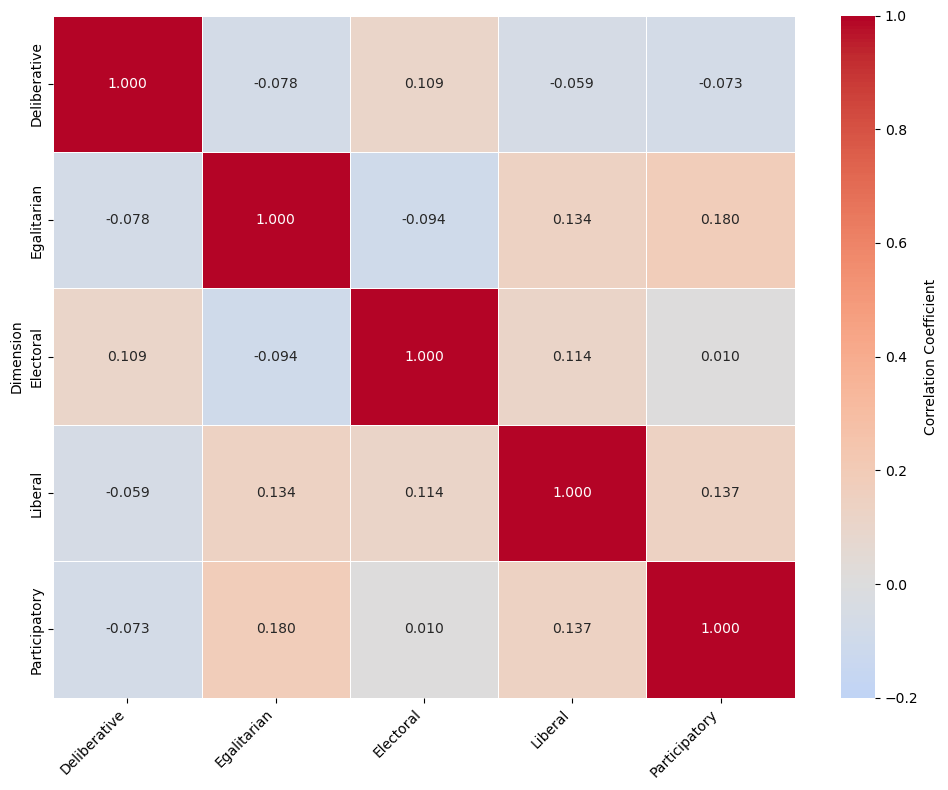

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create dataframe from correlation matrix
data = {
    'Dimension': ['Deliberative', 'Egalitarian', 'Electoral', 'Liberal', 'Participatory'],
    'Deliberative': [1,  -0.078, 0.109, -0.059, -0.073],
    'Egalitarian': [-0.078, 1, -0.094, 0.134, 0.180],
    'Electoral': [0.109, -0.094, 1, 0.114, 0.010],
    'Liberal': [-0.059, 0.134, 0.114, 1, 0.137],
    'Participatory': [-0.073, 0.180, 0.010, 0.137, 1]
}

df = pd.DataFrame(data).set_index('Dimension')

# Create heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='coolwarm',
                 center=0, vmin=-0.2, vmax=1,
                 linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap_1.png', dpi=500, bbox_inches='tight')
plt.show()


In [ ]:
from scipy.stats import pearsonr
import pandas as pd
df = pd.read_csv('/Users/yvette/Desktop/data/Final/cos_sim_dimensions.csv')
df['Dimension_Pair'] = df['Dimension 1'] + ' & ' + df['Dimension 2']
pivot_df = df.pivot_table(index=['Subcorpus', 'Bootstrap'], columns='Dimension_Pair', values='Cosine_Similarity')

# Calculate the correlation between the dimensions
correlation_matrix = pivot_df.corr()

# Display the correlation matrix
print(correlation_matrix)

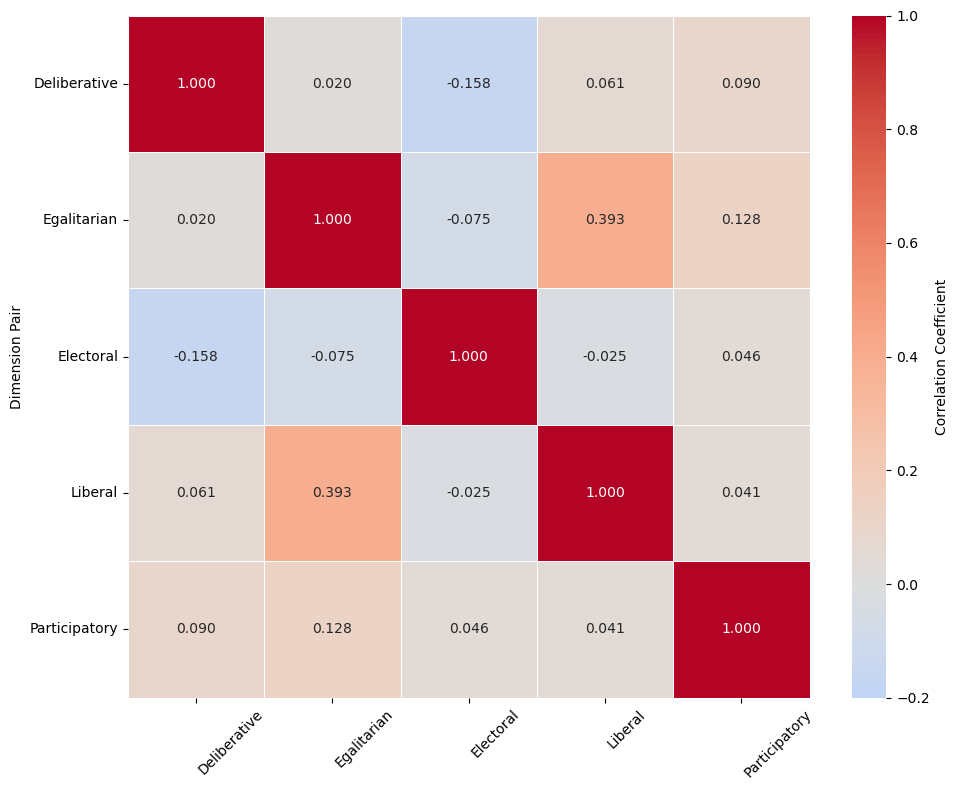

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create dataframe from correlation matrix
data = {
    'Dimension Pair': ['Deliberative', 'Egalitarian', 'Electoral', 'Liberal', 'Participatory'],
    'Deliberative': [1, 0.020, -0.158, 0.061, 0.090],
    'Egalitarian': [0.020, 1, -0.075, 0.393, 0.128],
    'Electoral': [-0.158, -0.075, 1, -0.025, 0.046],
    'Liberal': [0.061, 0.393, -0.025, 1, 0.041],
    'Participatory': [0.090, 0.128, 0.046, 0.041, 1]
}

df = pd.DataFrame(data).set_index('Dimension Pair')

# Create customized heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='coolwarm',
                 center=0, vmin=-0.2, vmax=1,
                 linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Improve readability
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_2.png', dpi=500, bbox_inches='tight')
plt.show()

In [4]:
import pandas as pd
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

def get_pole_vector(model, words):
    """Get average vector for a set of words"""
    vectors = []
    for word in words:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            continue
    return np.mean(vectors, axis=0) if vectors else None

def find_nearest_neighbors(model, pole_vector, topn=10):
    """Find top-N nearest words to a pole vector"""
    if pole_vector is None:
        return []
    
    similarities = {}
    for word in model.wv.key_to_index:
        similarities[word] = cosine_similarity(
            pole_vector.reshape(1, -1),
            model.wv[word].reshape(1, -1)
        )[0][0]
    
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]

year_ranges = [
    ("1971", "1980"),
    ("1981", "1990"),
    ("1991", "2000"),
    ("2001", "2010"),
    ("2011", "2020"),
    ("2021", "2024")
]

# Define the journals
journals = [
    "American Journal of Political Science",
    "British Journal of Political Science"
]


def analyze_neighbors_to_dataframe():
    results = []
    
    for start_year, end_year in year_ranges:
        for journal in journals:
            subcorpus = f"{start_year}-{end_year}_{journal}"
            
            for dim_name, poles in word_groups.items():
                pos_neighbors_all = []
                neg_neighbors_all = []
                
                for bootstrap in range(25):
                    model_path = f'/Users/yvette/Desktop/data/Final/bootstrapped_model_bigram/sg300win10c10iter10_{subcorpus}_boot{bootstrap}_.model'
                    
                    try:
                        model = Word2Vec.load(model_path)
                        
                        # Process positive pole
                        pos_vector = get_pole_vector(model, poles['positive'])
                        if pos_vector is not None:
                            pos_neighbors = find_nearest_neighbors(model, pos_vector, topn=5)
                            pos_neighbors_all.extend([word for word, score in pos_neighbors])
                        
                        # Process negative pole
                        neg_vector = get_pole_vector(model, poles['negative'])
                        if neg_vector is not None:
                            neg_neighbors = find_nearest_neighbors(model, neg_vector, topn=5)
                            neg_neighbors_all.extend([word for word, score in neg_neighbors])
                            
                    except Exception as e:
                        print(f"Error processing {model_path}: {str(e)}")
                        continue
                
                # Get top 5 most frequent neighbors across all bootstrap samples
                top5_pos = [word for word, count in Counter(pos_neighbors_all).most_common(5)]
                top5_neg = [word for word, count in Counter(neg_neighbors_all).most_common(5)]
                
                # Store results
                results.append({
                    'subcorpus': subcorpus,
                    'dimension': dim_name,
                    'top5_positive': ', '.join(top5_pos),
                    'top5_negative': ', '.join(top5_neg)
                })
    
    return pd.DataFrame(results)

# Run analysis and save to CSV
neighbors_df = analyze_neighbors_to_dataframe()
neighbors_df.to_csv('dimension_nearest_neighbors.csv', index=False)

# Display sample of results
print(neighbors_df.head())

                                         subcorpus  \
0  1971-1980_American Journal of Political Science   
1  1971-1980_American Journal of Political Science   
2  1971-1980_American Journal of Political Science   
3  1971-1980_American Journal of Political Science   
4  1971-1980_American Journal of Political Science   

                      dimension  \
0  Democracy  vs.  Dictatorship   
1                     Electoral   
2                       Liberal   
3                  Deliberative   
4                 Participatory   

                                       top5_positive  \
0  participation_america, dahl_robert, pluralism,...   
1  multi_party, voter_alignments, multiparty, ele...   
2  civil_liberties, warren_court, communism_confo...   
3  discretion, rationale, consensus, common_good,...   
4  decentralized, apportionment, suffrage, decent...   

                                       top5_negative  
0  fascism, dictatorship, fascist, participation_...  
1  appointment, a